In [1]:
import os, gzip, json, re
from plotnine import *
import pandas as pd
import io, os, time, re
import numpy as np
from numpy import array
import matplotlib.pyplot as plt

%matplotlib inline
from IPython.display import display, Markdown, Image, clear_output

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Dense, LSTM, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import \
    RMSprop, Adam, SGD
from tqdm.keras import TqdmCallback
import six

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# For data conditioning
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt

# Make results reproducible
from numpy.random import seed
seed(1)
#from tensorflow import set_random_seed
#set_random_seed(1)


In [2]:
# Make our plot a bit formal
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 10}
plt.rc('font', **font)


In [3]:
# Set input number of timestamps and training days
#
n_timestamp = 10
train_days = 1700000  # number of days to train from
testing_days = 50 # number of days to be predicted
n_epochs = 3
filter_on = 1

In [4]:
# Select model type
# 1: Single cell
# 2: Stacked
# 3: Bidirectional
#
model_type = 2

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
base_dir = "drive/MyDrive/airdata"
data_dir = os.path.join(
    os.getcwd(),
    base_dir
)
airdata = []

display(Markdown(f"Listing data files from: {data_dir}"))

generator = (file for file in os.listdir(data_dir) if (file.find(".json.gz") > 0))
for filegz in generator:
    display(Markdown(f"* Loading {filegz}"))
    try:
        with gzip.open(os.path.join(data_dir, filegz), 'rt') as file:
            for (i, line) in enumerate(file):
                #print(f"{filegz}:{i}", line.strip())
                json_line = json.loads(line.strip())
                airdata.append(json_line)
                    
    except EOFError:
        continue
    except Exception as e:
        print(f"Error while reading file {filegz}", type(e))
        raise e
display(Markdown("Done!"))

Listing data files from: /content/drive/MyDrive/airdata

* Loading air-20210212-153737.json.gz

* Loading air-20210326-110304.json.gz

* Loading air-20210212-060545.json.gz

* Loading air-20210212-060534.json.gz

* Loading air-20210415-234052.json.gz

* Loading air-20210308-213952.json.gz

* Loading air-20210212-060408.json.gz

* Loading air-20210212-153808.json.gz

* Loading air-20210308-214511.json.gz

* Loading air-20210212-153921.json.gz

* Loading air-20210218-233000.json.gz

* Loading air-20210212-060529.json.gz

Done!

In [7]:
dataset = pd.DataFrame(airdata)
if filter_on == 1:
  dataset['temperature'] = medfilt(dataset['temperature'], 3)
  dataset['temperature'] = gaussian_filter1d(dataset['temperature'], 1.2)

In [8]:
#
# Set number of training and testing data
# 
train_set = dataset[0:train_days].reset_index(drop=True)
test_set = dataset[train_days: train_days+testing_days].reset_index(drop=True)
training_set = train_set.iloc[:, 1:2].values
testing_set = test_set.iloc[:, 1:2].values

In [9]:
#
# Normalize data first
#
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.fit_transform(testing_set)

In [10]:
#
# Split data into n_timestamp
#
def data_split(sequence, n_timestamp):
    X = []
    y = []
    for i in range(len(sequence)):
        end_ix = i + n_timestamp
        if end_ix > len(sequence)-1:
            break
        # i to end_ix as input
        # end_ix as target output
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [11]:
X_train, y_train = data_split(training_set_scaled, n_timestamp)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test, y_test = data_split(testing_set_scaled, n_timestamp)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [12]:
if model_type == 1:
    # Single cell LSTM
    model = Sequential()
    model.add(LSTM(units = 50, activation='relu',input_shape = (X_train.shape[1], 1)))
    model.add(Dense(units = 1))
if model_type == 2:
    # Stacked LSTM
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
if model_type == 3:
    # Bidirectional LSTM
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))

In [13]:
#
# Start training
#
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train, y_train, epochs = n_epochs, batch_size = 32)
loss = history.history['loss']
epochs = range(len(loss))

Epoch 1/3
53125/53125 [==============================] - 1542s 29ms/step - loss: 5.7471e-04
Epoch 2/3
53125/53125 [==============================] - 1522s 29ms/step - loss: 4.0256e-06
Epoch 3/3
53125/53125 [==============================] - 1515s 29ms/step - loss: 3.5119e-06


In [14]:
#
# Get predicted data
#
y_predicted = model.predict(X_test)

In [15]:
#
# 'De-normalize' the data
#
y_predicted_descaled = sc.inverse_transform(y_predicted)
y_train_descaled = sc.inverse_transform(y_train)
y_test_descaled = sc.inverse_transform(y_test)
y_pred = y_predicted.ravel()
y_pred = [round(yx, 2) for yx in y_pred]
y_tested = y_test.ravel()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


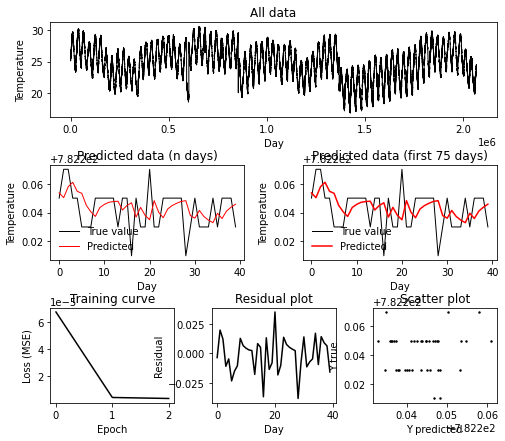

In [18]:
#
# Show results
#
plt.figure(figsize=(8,7))

plt.subplot(3, 1, 1)
plt.plot(dataset['temperature'], color = 'black', linewidth=1, label = 'True value')
plt.ylabel("Temperature")
plt.xlabel("Day")
plt.title("All data")


plt.subplot(3, 2, 3)
plt.plot(y_test_descaled, color = 'black', linewidth=1, label = 'True value')
plt.plot(y_predicted_descaled, color = 'red',  linewidth=1, label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Day")
plt.title("Predicted data (n days)")

plt.subplot(3, 2, 4)
plt.plot(y_test_descaled[0:75], color = 'black', linewidth=1, label = 'True value')
plt.plot(y_predicted_descaled[0:75], color = 'red', label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Day")
plt.title("Predicted data (first 75 days)")

plt.subplot(3, 3, 7)
plt.plot(epochs, loss, color='black')
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.title("Training curve")

plt.subplot(3, 3, 8)
plt.plot(y_test_descaled-y_predicted_descaled, color='black')
plt.ylabel("Residual")
plt.xlabel("Day")
plt.title("Residual plot")

plt.subplot(3, 3, 9)
plt.scatter(y_predicted_descaled, y_test_descaled, s=2, color='black')
plt.ylabel("Y true")
plt.xlabel("Y predicted")
plt.title("Scatter plot")

plt.subplots_adjust(hspace = 0.5, wspace=0.3)
plt.show()

In [19]:
mse = mean_squared_error(y_test_descaled, y_predicted_descaled)
r2 = r2_score(y_test_descaled, y_predicted_descaled)
print("mse=" + str(round(mse,2)))
print("r2=" + str(round(r2,2)))

mse=0.0
r2=-0.14


In [ ]:
df = pd.DataFrame(airdata)
df["datetime"] = pd.to_datetime(df["datetime"], unit='s')
df["hour"] = [dt.hour for dt in df.datetime]
df.head()

In [ ]:
# Split and Scaling
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
#X = df_train.loc[:, useful_cols].values
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(df_train.drop('datetime',axis=1))
X_test = min_max_scaler.transform(df_test.drop('datetime',axis=1))